In [694]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from matplotlib.patches import Ellipse, Rectangle
import requests
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from madxtools.plot_tool import *

from t12_functions import *
from pybt.tools.particles import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


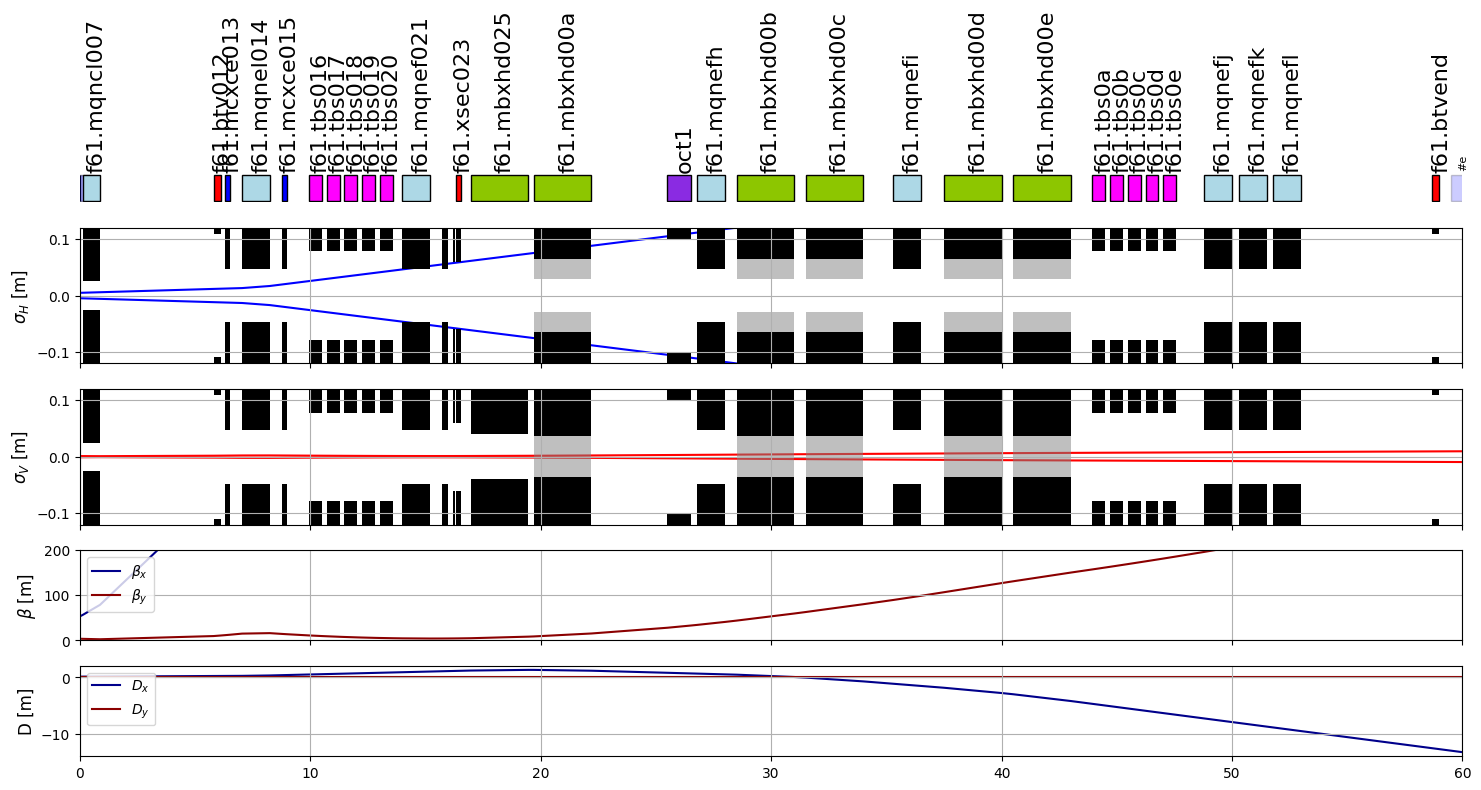

In [703]:
p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, ex, ey, sige = calc_initial_condition(2.0)

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("madx_files/f61t12_early.seq")
madx.call("madx_files/f61t12_early.str")

madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,k3,DELTAP, BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
# madx.input('SELECT, FLAG=aperture, COLUMN=apertype;')

madx.input("kQFN1 = "+str(0.0)+";")
madx.input("kQDN2 = "+str(-0.221974)+";")
madx.input("kQFN3 = "+str(0.0)+";")

madx.input("k3OCT1 = "+str(1000)+";")

# madx.input("kQFN4 = "+str(0.4797)+";")
# madx.input("kQDN5 = "+str(-0.173)+";")
# madx.input("kQFN6 = "+str(0.1986)+";")
# madx.input("kQFN7 = "+str(0.4797)+";")
# madx.input("kQDN8 = "+str(-0.173)+";")

madx.use(sequence="f61t12")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

plot_graph_with_dispersion(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,2,2])

Text(0, 0.5, 'Beam-Eveloppe(95%) [mm]')

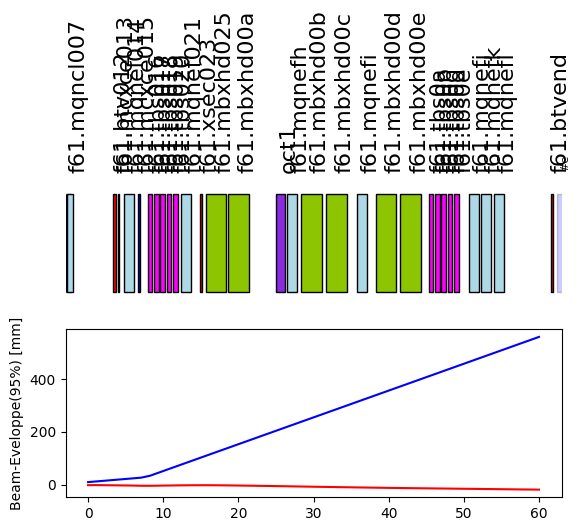

In [704]:
fig, ax = plt.subplots(2,1)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 2)*1000, alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 2)*1000, alpha=1.0, color ="r", zorder=0)
ax[1].set_ylabel("Beam-Eveloppe(95%) [mm]")

In [705]:
############################## CREATE PARTICLES DISTRIBUTION ##############################

number_of_particles = 5000
# Random distributionsa
x = np.random.normal(0, 0.03, number_of_particles)
xp = np.random.normal(0, 0.003, number_of_particles)
y = np.random.normal(0, 0.02, number_of_particles)
yp = np.random.normal(0, 0.002, number_of_particles)
pt = np.random.normal(0, sige, number_of_particles)

dist = beam_distrib_norm(alfx0, betx0, ex, number_of_particles, 1)
x = dist[:, 0]
xp = dist[:, 1]
dist = beam_distrib_norm(alfy0, bety0, ey, number_of_particles, 1)
y = dist[:, 0]
yp = dist[:, 1]

init_dist = np.column_stack((x, xp, y, yp, pt))

In [706]:
madx.input('''
USE, SEQUENCE = f61t12;
PTC_CREATE_UNIVERSE;
PTC_CREATE_LAYOUT, MODEL = 1, METHOD = 2, EXACT = FALSE, NST = 4;
''')

for name in twiss.index:
    madx.input(f"PTC_OBSERVE, PLACE = {name};")

# madx.input("PTC_START, X = 0.03, PX = 0.002, Y = 0.00, PY = 0.000, PT=0.1")
for particle in init_dist:
    madx.input(f'PTC_START, X= {particle[0]}, px={particle[1]}, y={particle[2]}, py={particle[3]}, pt={particle[4]};')
    
madx.input('''
PTC_TRACK, TURNS=1, ICASE=5, ELEMENT_BY_ELEMENT=TRUE, DUMP=FALSE, ONETABLE=TRUE, RECLOSS=TRUE, CLOSED_ORBIT=FALSE, MAXAPER={100,100,100,100,100,100};
PTC_TRACK_END;
''')

ptc_output = madx.table.trackone.dframe()
ptc_lost = madx.table.trackloss.dframe()

(-0.2, 0.2)

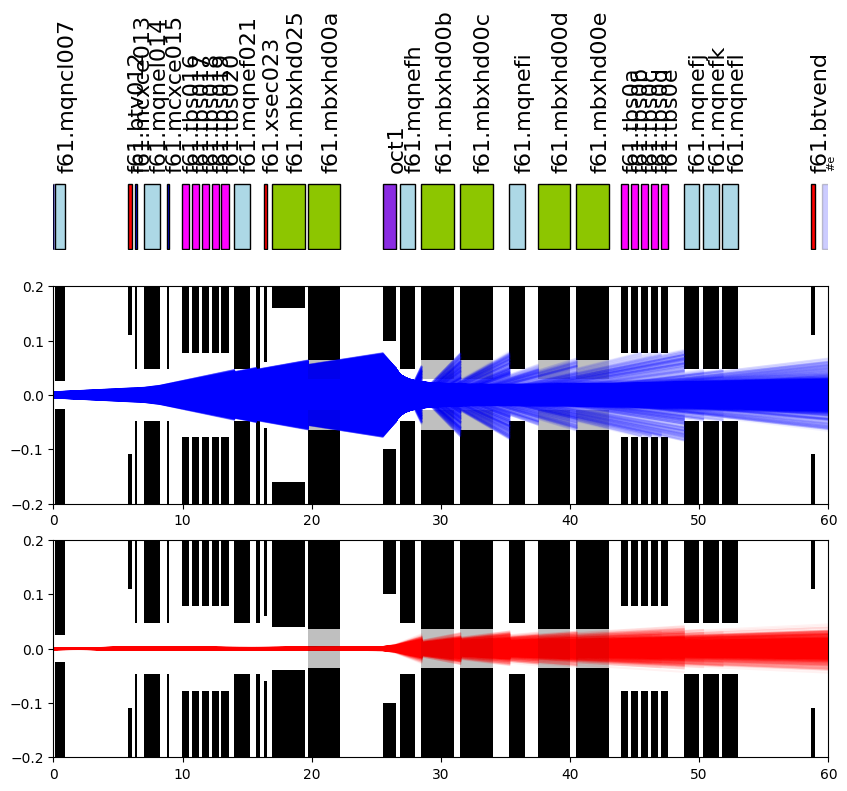

In [707]:
fig, ax = plt.subplots(3,1, figsize=(10, 8), height_ratios=[1,2,2])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

for i in range(int(number_of_particles)):
    i=i+1

    ax[1].plot(ptc_output[ptc_output.number == i].s, ptc_output[ptc_output.number == i].x, color="b", alpha=0.05)
    ax[2].plot(ptc_output[ptc_output.number == i].s, ptc_output[ptc_output.number == i].y, color="r", alpha=0.05)

draw_aperture_rectcircle(ax[1], ax[2], twiss,"aper_1", "aper_2", "aper_3")
draw_aperture_racetrackH(ax[1], twiss,"aper_1", "aper_2", "aper_3","aper_4")
draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")

draw_aperture_racetrackV(ax[2], twiss,"aper_1", "aper_2", "aper_3","aper_4")
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")

ax[1].set_xlim(0,twiss.s[-1])
ax[2].set_xlim(0,twiss.s[-1])
ax[1].set_ylim(-0.2, 0.2)
ax[2].set_ylim(-0.2, 0.2)

Correlation Coefficient: -0.8456394624082177
3.308809567788739
The arrays are highly correlated.


(-3.5, 3.5)

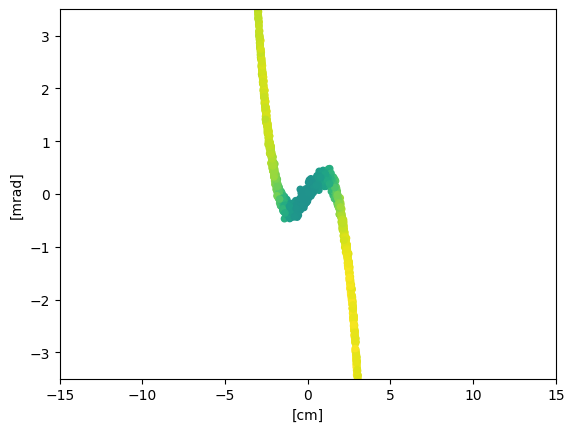

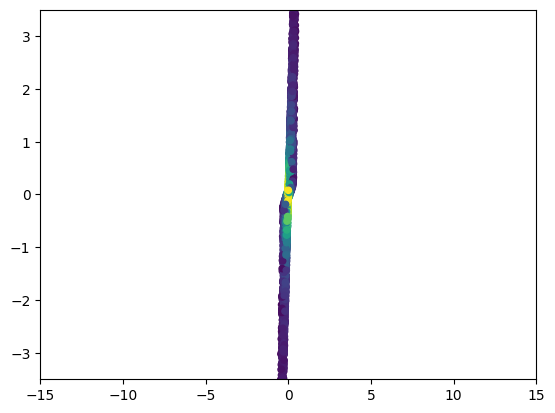

In [708]:
from scipy.stats import gaussian_kde

x = ptc_output.where(ptc_output.s == twiss.loc["oct1"].s).dropna().x
x = np.array(x)*100
px = ptc_output.where(ptc_output.s == twiss.loc["oct1"].s).dropna().px
px = np.array(px)*1000
y = ptc_output.where(ptc_output.s == twiss.loc["oct1"].s).dropna().y
y = np.array(y)*100
py = ptc_output.where(ptc_output.s == twiss.loc["oct1"].s).dropna().py
py = np.array(py)*1000

fig, ax = plt.subplots()
xy = np.vstack([x,px])
z = gaussian_kde(xy)(xy)
ax.scatter(x, px, c=z, s=20)
ax.set_xlim(-15, 15)
ax.set_ylim(-3.5, 3.5)
ax.set_xlabel("[cm]")
ax.set_ylabel("[mrad]")


# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(x, px)[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient}")
print(np.std(x))
if abs(correlation_coefficient) >= 0.7:
    print("The arrays are highly correlated.")
else:
    print("The arrays are not highly correlated.")

fig, ax = plt.subplots()
xy = np.vstack([y,py])
z = gaussian_kde(xy)(xy)
ax.scatter(y, py, c=z, s=20)
ax.set_xlim(-15, 15)
ax.set_ylim(-3.5, 3.5)

(-3.5, 3.5)

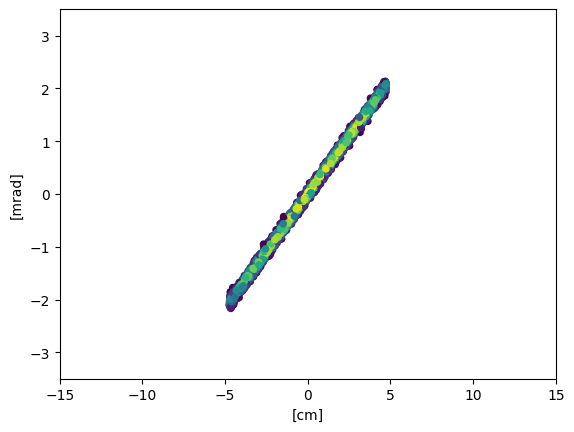

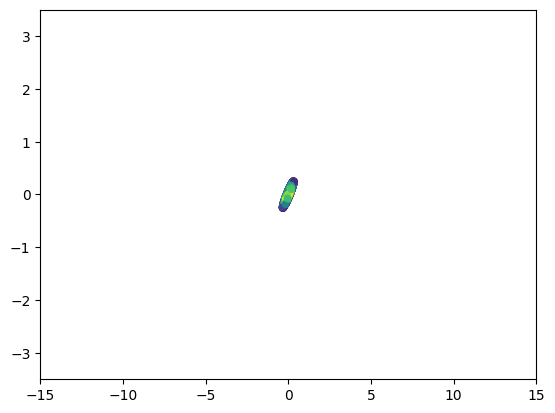

In [701]:
from scipy.stats import gaussian_kde

location = "f61.mqnefh"
x = ptc_output.where(ptc_output.s == twiss.loc["f61.mqnefh"].s).dropna().x
x = np.array(x)*100
px = ptc_output.where(ptc_output.s == twiss.loc["f61.mqnefh"].s).dropna().px
px = np.array(px)*1000
y = ptc_output.where(ptc_output.s == twiss.loc["f61.mqnefh"].s).dropna().y
y = np.array(y)*100
py = ptc_output.where(ptc_output.s == twiss.loc["f61.mqnefh"].s).dropna().py
py = np.array(py)*1000

fig, ax = plt.subplots()
xy = np.vstack([x,px])
z = gaussian_kde(xy)(xy)
ax.scatter(x, px, c=z, s=20)
ax.set_xlim(-15, 15)
ax.set_ylim(-3.5, 3.5)
ax.set_xlabel("[cm]")
ax.set_ylabel("[mrad]")

fig, ax = plt.subplots()
xy = np.vstack([y,py])
z = gaussian_kde(xy)(xy)
ax.scatter(y, py, c=z, s=20)
ax.set_xlim(-15, 15)
ax.set_ylim(-3.5, 3.5)

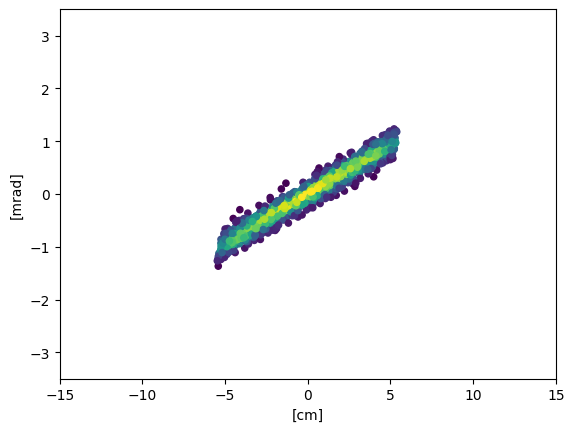

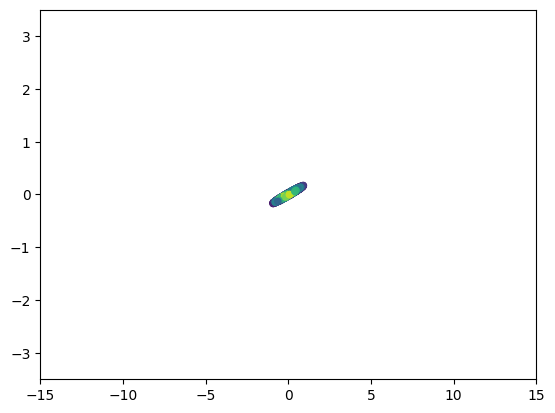

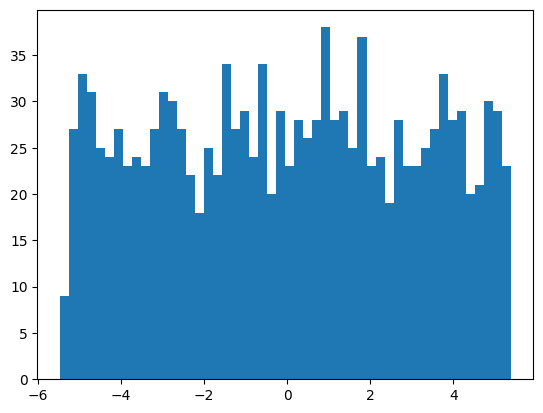

In [702]:
from scipy.stats import gaussian_kde

location = "f61.btvend"
x = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().x
x = np.array(x)*100
px = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().px
px = np.array(px)*1000
y = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().y
y = np.array(y)*100
py = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().py
py = np.array(py)*1000

fig, ax = plt.subplots()
xy = np.vstack([x,px])
z = gaussian_kde(xy)(xy)
ax.scatter(x, px, c=z, s=20)
ax.set_xlim(-15, 15)
ax.set_ylim(-3.5, 3.5)
ax.set_xlabel("[cm]")
ax.set_ylabel("[mrad]")

fig, ax = plt.subplots()
xy = np.vstack([y,py])
z = gaussian_kde(xy)(xy)
ax.scatter(y, py, c=z, s=20)
ax.set_xlim(-15, 15)
ax.set_ylim(-3.5, 3.5)

fig, ax = plt.subplots()
ax.hist(x, bins=50);